# Changes to Particle Flow Network for Deep Sets

## Goals
(In Order)
 - [ ] Experiment with adding TNet to Inputs
 - [ ] Add dropout layers in latent space network
 - [ ] Add Attention Layers
 - [ ] Build Model which handles Tracks Separately

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

In [2]:
path_prefix = '/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model

In [5]:
import energyflow as ef
from energyflow.archs import PFN

In [6]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 3000

# Models

In [41]:
import keras as K
import keras.backend as Kb
from tensorflow.keras import activations

def ParticleFlow_base(num_points, num_features, name="Russell Flow Network"):
    
    mask_val=0.0

    inputs = keras.Input(shape=(num_points, num_features), name='input')

    dense_0 = layers.Dense(100,name='td_0', activation=activations.relu)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    
    dense_1 = layers.Dense(100,name='td_1', activation=activations.relu)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(t_dist_0)
    
    dense_2 = layers.Dense(128,name='td_2', activation=activations.relu)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(t_dist_1)
    
    lambda_layer = layers.Lambda(lambda X: X * Kb.cast(Kb.not_equal(X, mask_val), Kb.dtype(X)), output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, t_dist_2])
    
    dense_3 = layers.Dense(100, name='dense_0', activation=activations.relu)(sum_layer)
    
    dense_4 = layers.Dense(100, name='dense_1')(dense_3)
    
    dense_5 = layers.Dense(100, name='dense_2', activation=activations.relu)(dense_4)
    
    dense_6 = layers.Dense(1, name='output', activation=activations.relu)(dense_5)
    
    return keras.Model(inputs=inputs, outputs=dense_6, name=name)

In [42]:
muh_modle = ParticleFlow_base(num_points=100, num_features=5)
muh_modle.summary()

Model: "Russell Flow Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 5)]     0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 100, 100)     600         input[0][0]                      
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 100, 100)     10100       t_dist_0[0][0]                   
__________________________________________________________________________________________________
mask (Lambda)                   (None, 100, 5)       0           input[0][0]                      
_______________________________________________________________________________

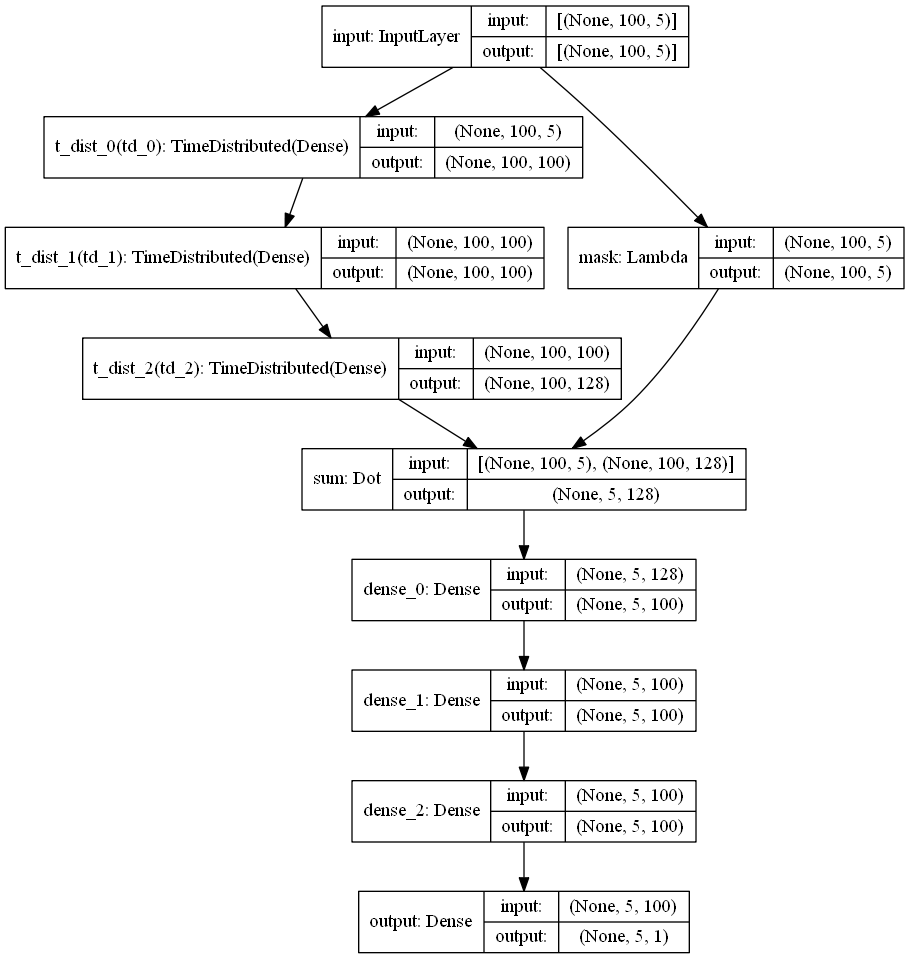

In [44]:
tf.keras.utils.plot_model(muh_modle, to_file=plotpath+"pfn.png",show_shapes=True)